In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import pickle
from umap import UMAP
import numpy as np
from sklearn.decomposition import PCA


class Languages:
    si = 'SI'
    gb = 'GB'
    hu = 'HU'
    ua = 'UA'
    all = [si, gb, hu, ua]
plot_artefacts = Path('artefacts/plots')

In [3]:
topic_artefacts = Path('artefacts/by_topic/topic_csvs')
embedding_artefacts_base = Path('artefacts/bojan')
embedding_artefacts = {
    Languages.si: pickle.load(open(embedding_artefacts_base / 'ParlaMint_SI_embeddings_truncated.pkl', 'rb')),
    Languages.gb: pickle.load(open(embedding_artefacts_base / 'ParlaMint_GB_commons_embeddings_truncated.pkl', 'rb')),
    Languages.ua: pickle.load(open(embedding_artefacts_base / 'ParlaMint_UA_embeddings_truncated.pkl', 'rb')),
    Languages.hu: pickle.load(open(embedding_artefacts_base / 'ParlaMint_HU_embeddings_truncated.pkl', 'rb')),
}

In [4]:
topic_names = ['war', 'eu', 'healthcare', 'gender']
topics = {
    t: {
        l: pd.read_csv(topic_artefacts / f'{t}_{l}.csv') for l in tqdm(embedding_artefacts)
    } for t in topic_names
}

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.68it/s]


# GPT Context
Dataframes:
- topic_names = ['war', 'eu', 'healthcare', 'gender']
- topics[<topic_name>][Languages.<si/gb/ua/hu>] with columns:
['ID', 'Title', 'Date', 'Body', 'Term', 'Session', 'Meeting', 'Sitting', 'Agenda', 'Subcorpus', 'Speaker_role', 'Speaker_MP', 'Speaker_Minister', 'Speaker_party', 'Speaker_party_name', 'Party_status', 'Speaker_name', 'Speaker_gender', 'Speaker_birth', 'speech', 'speech_split', 'sentiment', 'speech_length']
- embedding_artefacts[Languages.<si/gb/ua/hu>]: dict of embeddings with keys = speech IDs

In [240]:
print(list(embedding_artefacts[Languages.si].columns))

['Unnamed: 0', 'ID', 'Title', 'Date', 'Body', 'Term', 'Session', 'Meeting', 'Sitting', 'Agenda', 'Subcorpus', 'Speaker_role', 'Speaker_MP', 'Speaker_Minister', 'Speaker_party', 'Speaker_party_name', 'Party_status', 'Speaker_name', 'Speaker_gender', 'Speaker_birth', 'speech', 'speech_split', 'sentiment']


In [6]:
def get_embeddings_for_speaker(embeddings, speech_ids):
    return np.average([embeddings[sid] for sid in speech_ids if sid in embeddings], axis=0)

print(list((topics['war'][Languages.si].columns)))

['ID', 'Title', 'Date', 'Body', 'Term', 'Session', 'Meeting', 'Sitting', 'Agenda', 'Subcorpus', 'Speaker_role', 'Speaker_MP', 'Speaker_Minister', 'Speaker_party', 'Speaker_party_name', 'Party_status', 'Speaker_name', 'Speaker_gender', 'Speaker_birth', 'speech', 'speech_split', 'sentiment', 'speech_length']


In [195]:
lang = Languages.gb
topic_df = topics['war'][lang]


def get_color_for_party(party):
    if party == 'LAB':
        return 'blue'
    elif party == 'CON':
        return 'red'
    else:
        return 'white'


embeddings_subset = []
colors = []
for speaker_name, speaker_group in topic_df.groupby('Speaker_name'):
    embeddings_subset.append(get_embeddings_for_speaker(embedding_artefacts[lang], speaker_group.ID.values))
    sample = next(speaker_group.iterrows())[1]
    colors.append(get_color_for_party(sample.Speaker_party))
len(embeddings_subset)

894

In [ ]:
parties = []
for party, subc in topics['war'][Languages.si].groupby('Speaker_party'):
    parties.append((party, len(subc)))
for p in sorted(parties, key=lambda x: x[1], reverse=True):
    print(p)


# Polarization grid

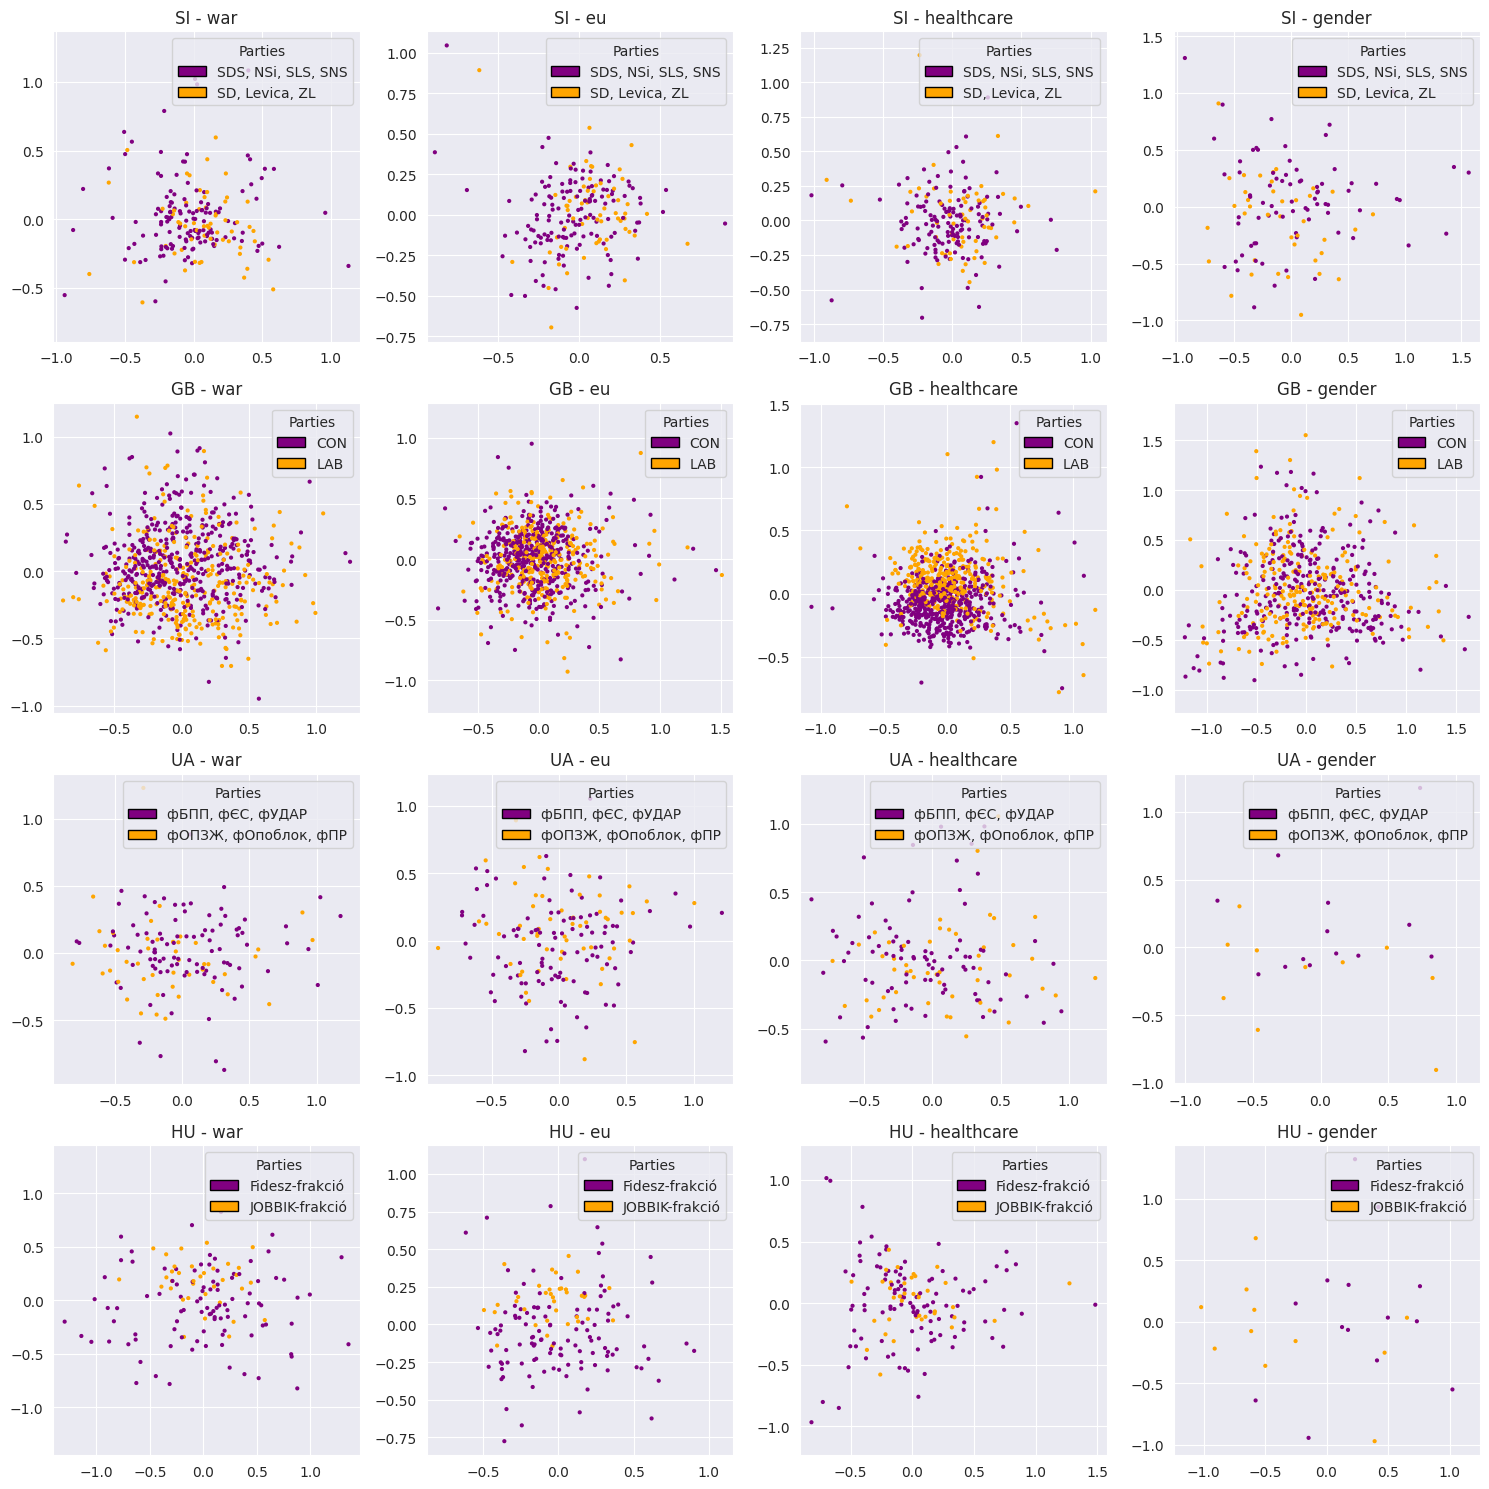

In [7]:
from matplotlib.patches import Patch

c1 = 'purple'
c2 = 'orange'

def get_data_for_topic(topic, lang, parties, embeddings_artefacts):
    topic_df = topics[topic][lang]

    # Only include data for specified parties
    topic_df = topic_df[topic_df['Speaker_party'].isin(parties[0] + parties[1])]
    embeddings_subset = []
    colors = []
    for speaker_name, speaker_group in topic_df.groupby('Speaker_name'):
        embeddings_subset.append(get_embeddings_for_speaker(embeddings_artefacts[lang], speaker_group.ID.values))
        sample = next(speaker_group.iterrows())[1]
        if sample.Speaker_party in parties[0]:
            colors.append(c1)
        elif sample.Speaker_party in parties[1]:
            colors.append(c2)
        else:
            colors.append('white')

    return embeddings_subset, colors

def apply_dimred(embeddings_subset):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings_subset)
    # reducer = UMAP(n_neighbors=5,
    #                min_dist=0.1,
    #                n_components=2,
    #                metric='euclidean')
    # reduced_embeddings = reducer.fit_transform(embeddings_subset)
    return reduced_embeddings

def plot_topic(ax, reduced_embeddings, colors, legend, lang, topic):
    ax.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=colors,
        s=4,
    )
    ax.set_aspect('equal', 'datalim')
    ax.set_title(f'{lang} - {topic}')  # Add a title to each subplot

    # Create legend
    legend_elements = [Patch(facecolor=c, edgecolor='black', label=party) for party, c in legend]
    ax.legend(handles=legend_elements, title='Parties', loc='upper right')

def plot_languages(party_combinations, topic_names, embeddings_artefacts, plot_artefacts):
    fig, axs = plt.subplots(4, 4, figsize=(15, 15))  # Prepare a 4x4 grid of subplots

    # Iterate over each language
    for i, (lang, parties) in enumerate(party_combinations.items()):
        # Iterate over each topic
        for j, topic in enumerate(topic_names):
            legend = [(', '.join(parties[0]), c1), (', '.join(parties[1]), c2)]

            embeddings_subset, colors = get_data_for_topic(topic, lang, parties, embeddings_artefacts)
            reduced_embeddings = apply_dimred(embeddings_subset)
            plot_topic(axs[i][j], reduced_embeddings, colors, legend, lang, topic)

    plt.tight_layout()  # Adjust subplot parameters to give specified padding
    plt.savefig(plot_artefacts / 'polarization_grid.png', dpi=300)  # Save the figure
    plt.show()  # Display the figure

party_combinations = {
    Languages.si: (('SDS', 'NSi', 'SLS', 'SNS'), ('SD', 'Levica', 'ZL')),
    Languages.gb: (('CON',), ('LAB',)),
    Languages.ua: (('фБПП', 'фЄС', 'фУДАР'), ('фОПЗЖ', 'фОпоблок', 'фПР')),
    Languages.hu: (('Fidesz-frakció',), ('JOBBIK-frakció',)),
}

plot_languages(party_combinations, topic_names, embedding_artefacts, plot_artefacts)